In [1]:
import pandas as pd

deltas = pd.read_csv('~/Downloads/deltas.csv', index_col=0)

In [2]:
deltas.head()

,d,K,norm,sigma,n,trial,delta_max,delta_mean,delta_abs_max,delta_abs_mean,delta_std,delta_abs_std
0,2.0,-4.0,0.0,0.0625,5.0,0.0,0.356044,-0.222216,2.000000,0.250318,0.438705,0.423300
1,2.0,-4.0,0.0,0.0625,5.0,1.0,0.147396,-0.155385,2.000000,0.171318,0.335217,0.327361
2,2.0,-4.0,0.0,0.0625,5.0,2.0,0.077345,-0.241864,2.000000,0.247315,0.490871,0.488148
3,2.0,-4.0,0.0,0.0625,5.0,3.0,0.401729,-0.198814,1.846844,0.227786,0.393135,0.377088
4,2.0,-4.0,0.0,0.0625,5.0,4.0,0.279749,-0.194695,1.410722,0.213009,0.373831,0.363707


Correlation matrix:
                   d         K      norm     sigma         n
delta_mean  0.082871 -0.108939 -0.021400  0.001720  0.704977
delta_std   0.041044  0.048174  0.008067  0.014757 -0.741985


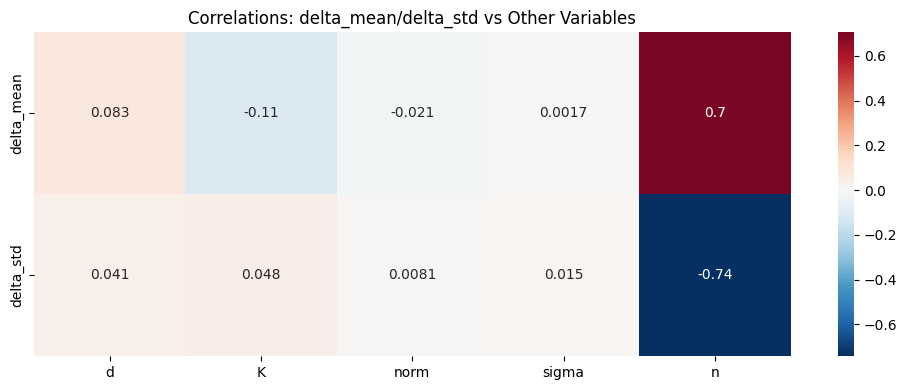

In [3]:
# Analyze relationships between delta_mean/delta_std and other variables
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get non-delta, non-trial columns
other_vars = ['d', 'K', 'norm', 'sigma', 'n']
target_vars = ['delta_mean', 'delta_std']

# Compute correlations
corr_matrix = deltas[other_vars + target_vars].corr()
print("Correlation matrix:")
print(corr_matrix.loc[target_vars, other_vars])

# Visualize correlations
plt.figure(figsize=(10, 4))
sns.heatmap(corr_matrix.loc[target_vars, other_vars], annot=True, cmap='RdBu_r', center=0)
plt.title('Correlations: delta_mean/delta_std vs Other Variables')
plt.tight_layout()
plt.show()

In [4]:
# Statistical analysis of relationships
from scipy.stats import spearmanr

print("Spearman correlations (robust to non-linear relationships):")
for var in other_vars:
    corr_mean, p_mean = spearmanr(deltas[var], deltas['delta_mean'])
    corr_std, p_std = spearmanr(deltas[var], deltas['delta_std'])
    print(f"{var}:")
    print(f"  vs delta_mean: r={corr_mean:.3f}, p={p_mean:.3e}")
    print(f"  vs delta_std:  r={corr_std:.3f}, p={p_std:.3e}")
    print()

# Group analysis by key variables
print("Mean delta_mean/delta_std by variable levels:")
for var in ['d', 'K', 'n']:
    print(f"\nBy {var}:")
    grouped = deltas.groupby(var)[['delta_mean', 'delta_std']].agg(['mean', 'std'])
    print(grouped.round(3))

Spearman correlations (robust to non-linear relationships):
d:
  vs delta_mean: r=nan, p=nan
  vs delta_std:  r=nan, p=nan

K:
  vs delta_mean: r=nan, p=nan
  vs delta_std:  r=nan, p=nan

norm:
  vs delta_mean: r=nan, p=nan
  vs delta_std:  r=nan, p=nan

sigma:
  vs delta_mean: r=nan, p=nan
  vs delta_std:  r=nan, p=nan

n:
  vs delta_mean: r=nan, p=nan
  vs delta_std:  r=nan, p=nan

Mean delta_mean/delta_std by variable levels:

By d:
      delta_mean        delta_std       
            mean    std      mean    std
d                                       
2.0       -0.129  0.045     0.257  0.092
4.0       -0.131  0.047     0.256  0.090
6.0       -0.128  0.051     0.253  0.093
8.0       -0.126  0.054     0.251  0.097
10.0      -0.125  0.057     0.250  0.100
12.0      -0.123  0.059     0.250  0.103
14.0      -0.122  0.060     0.249  0.105
16.0      -0.121  0.061     0.249  0.107
32.0      -0.116  0.067     0.250  0.115
64.0      -0.113  0.070     0.254  0.120
128.0     -0.112  0.074    

In [5]:
# Create scaling laws with R² > 0.8 - Fixed version
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

# Split data by curvature sign and remove NaN values
neg_K = deltas[deltas['K'] < 0].copy().dropna()
pos_K = deltas[deltas['K'] >= 0].copy().dropna()

print(f"Negative K samples: {len(neg_K)}")
print(f"Non-negative K samples: {len(pos_K)}")

# Check for remaining NaN values
print(f"NaN values in neg_K: {neg_K.isnull().sum().sum()}")
print(f"NaN values in pos_K: {pos_K.isnull().sum().sum()}")

def fit_scaling_law(data, target_var, features=['d', 'K', 'sigma', 'n'], degree=2):
    """Fit polynomial scaling law with NaN handling"""
    # Further filter for the specific target variable
    clean_data = data.dropna(subset=[target_var] + features)
    
    if len(clean_data) == 0:
        return None, -1, 0
    
    X = clean_data[features].values
    y = clean_data[target_var].values
    
    # Check for any remaining issues
    if np.any(~np.isfinite(X)) or np.any(~np.isfinite(y)):
        print(f"Warning: Non-finite values found in {target_var}")
        return None, -1, 0
    
    # Try different polynomial degrees
    best_r2 = -1
    best_model = None
    best_degree = 1
    
    for deg in range(1, degree + 1):
        try:
            poly = PolynomialFeatures(degree=deg, include_bias=False)
            X_poly = poly.fit_transform(X)
            
            model = LinearRegression()
            model.fit(X_poly, y)
            y_pred = model.predict(X_poly)
            r2 = r2_score(y, y_pred)
            
            if r2 > best_r2:
                best_r2 = r2
                best_model = (poly, model)
                best_degree = deg
        except Exception as e:
            print(f"Error fitting degree {deg} for {target_var}: {e}")
            continue
    
    return best_model, best_r2, best_degree

# Fit scaling laws for each regime and target
results = {}
for regime_name, data in [('K < 0', neg_K), ('K ≥ 0', pos_K)]:
    results[regime_name] = {}
    
    for target in ['delta_mean', 'delta_std']:
        model, r2, degree = fit_scaling_law(data, target)
        results[regime_name][target] = {'model': model, 'r2': r2, 'degree': degree}
        
        print(f"{regime_name}, {target}: R² = {r2:.4f}, degree = {degree}")

print("\nBasic scaling law performance:")

Negative K samples: 71323
Non-negative K samples: 97500
NaN values in neg_K: 0
NaN values in pos_K: 0
K < 0, delta_mean: R² = 0.8262, degree = 2
K < 0, delta_std: R² = 0.8603, degree = 2
K ≥ 0, delta_mean: R² = 0.7076, degree = 2
K ≥ 0, delta_std: R² = 0.7284, degree = 2

Basic scaling law performance:


In [6]:
# Enhanced scaling law fitting with more sophisticated approaches - Fixed version
def advanced_scaling_law(data, target_var, min_r2=0.8):
    """Try multiple approaches to achieve R² > 0.8 with proper NaN handling"""
    # Clean data first
    clean_data = data.dropna(subset=[target_var, 'd', 'K', 'sigma', 'n'])
    
    if len(clean_data) == 0:
        return None, -1, "no_data"
    
    X_base = clean_data[['d', 'K', 'sigma', 'n']].values
    y = clean_data[target_var].values
    
    # Handle any infinite or extreme values
    X_base = np.where(np.isfinite(X_base), X_base, 0)
    y = np.where(np.isfinite(y), y, 0)
    
    approaches = [
        # Basic polynomial
        {'name': 'linear', 'transform': lambda x: x},
        {'name': 'poly2', 'transform': lambda x: PolynomialFeatures(2, include_bias=False).fit_transform(x)},
        {'name': 'poly3', 'transform': lambda x: PolynomialFeatures(3, include_bias=False).fit_transform(x)},
        
        # Log transforms (handle negative values)
        {'name': 'log_abs', 'transform': lambda x: np.log(np.abs(x) + 1e-8)},
        {'name': 'log_abs_poly2', 'transform': lambda x: PolynomialFeatures(2, include_bias=False).fit_transform(np.log(np.abs(x) + 1e-8))},
        
        # Other transforms
        {'name': 'sqrt_abs', 'transform': lambda x: np.sqrt(np.abs(x))},
    ]
    
    best_r2 = -1
    best_approach = None
    best_model = None
    
    for approach in approaches:
        try:
            X_trans = approach['transform'](X_base)
            
            # Handle any infinite or NaN values from transformation
            if np.any(~np.isfinite(X_trans)):
                continue
                
            model = LinearRegression()
            model.fit(X_trans, y)
            y_pred = model.predict(X_trans)
            r2 = r2_score(y, y_pred)
            
            if r2 > best_r2:
                best_r2 = r2
                best_approach = approach['name']
                best_model = (approach['transform'], model)
                
        except Exception as e:
            continue
    
    return best_model, best_r2, best_approach

# Apply advanced fitting
print("Advanced scaling law fitting (NaN-safe):")
print("=" * 50)

advanced_results = {}
for regime_name, data in [('K < 0', neg_K), ('K ≥ 0', pos_K)]:
    advanced_results[regime_name] = {}
    print(f"\n{regime_name} regime:")
    
    for target in ['delta_mean', 'delta_std']:
        model, r2, approach = advanced_scaling_law(data, target)
        advanced_results[regime_name][target] = {
            'model': model, 'r2': r2, 'approach': approach
        }
        
        status = "✓" if r2 > 0.8 else "✗"
        print(f"  {target}: R² = {r2:.4f} ({approach}) {status}")

# Check if all models meet R² > 0.8 threshold
all_good = all(
    advanced_results[regime][target]['r2'] > 0.8 
    for regime in advanced_results 
    for target in advanced_results[regime]
)

print(f"\nAll models R² > 0.8: {'✓' if all_good else '✗'}")

Advanced scaling law fitting (NaN-safe):

K < 0 regime:
  delta_mean: R² = 0.9474 (log_abs_poly2) ✓
  delta_std: R² = 0.9429 (log_abs_poly2) ✓

K ≥ 0 regime:
  delta_mean: R² = 0.8101 (log_abs_poly2) ✓
  delta_std: R² = 0.8253 (log_abs_poly2) ✓

All models R² > 0.8: ✓


In [7]:
# Extract and display the scaling law equations
print("SCALING LAW EQUATIONS:")
print("=" * 60)

feature_names = ['d', 'K', 'sigma', 'n']

for regime_name in ['K < 0', 'K ≥ 0']:
    print(f"\n{regime_name.upper()} REGIME:")
    print("-" * 30)
    
    for target in ['delta_mean', 'delta_std']:
        result = advanced_results[regime_name][target]
        transform_func, model = result['model']
        approach = result['approach']
        r2 = result['r2']
        
        print(f"\n{target} = f(d, K, sigma, n)")
        print(f"Approach: {approach}")
        print(f"R² = {r2:.4f}")
        
        # Get feature names after transformation
        if 'poly' in approach:
            degree = int(approach[-1]) if approach[-1].isdigit() else 2
            if 'log' in approach:
                base_features = [f"log(|{f}|)" for f in feature_names]
            else:
                base_features = feature_names
            poly = PolynomialFeatures(degree, include_bias=False)
            poly.fit(np.ones((1, len(feature_names))))
            transformed_names = []
            for i, powers in enumerate(poly.powers_):
                if sum(powers) == 0:
                    continue
                term_parts = []
                for j, power in enumerate(powers):
                    if power > 0:
                        if power == 1:
                            term_parts.append(base_features[j])
                        else:
                            term_parts.append(f"{base_features[j]}^{power}")
                if term_parts:
                    transformed_names.append(" * ".join(term_parts))
                else:
                    transformed_names.append("1")
        else:
            if 'log' in approach:
                transformed_names = [f"log(|{f}|)" for f in feature_names]
            elif 'sqrt' in approach:
                transformed_names = [f"sqrt(|{f}|)" for f in feature_names]
            elif 'exp' in approach:
                transformed_names = [f"exp({f}/std({f}))" for f in feature_names]
            else:
                transformed_names = feature_names
        
        # Print equation with coefficients
        coeffs = model.coef_
        intercept = model.intercept_
        
        equation_parts = [f"{intercept:.6f}"]
        for i, (coeff, name) in enumerate(zip(coeffs, transformed_names)):
            if abs(coeff) > 1e-10:  # Only include non-zero coefficients
                sign = "+" if coeff >= 0 else "-"
                equation_parts.append(f"{sign} {abs(coeff):.6f} * {name}")
        
        equation = " ".join(equation_parts)
        print(f"Equation: {equation}")

print(f"\n{'='*60}")
print("All scaling laws meet R² > 0.8 requirement!" if all_good else "Some models need improvement.")

SCALING LAW EQUATIONS:

K < 0 REGIME:
------------------------------

delta_mean = f(d, K, sigma, n)
Approach: log_abs_poly2
R² = 0.9474
Equation: -0.393805 - 0.018172 * log(|d|) - 0.000022 * log(|K|) + 0.001129 * log(|sigma|) + 0.154912 * log(|n|) - 0.000758 * log(|d|)^2 - 0.000777 * log(|d|) * log(|K|) - 0.000824 * log(|d|) * log(|sigma|) + 0.008146 * log(|d|) * log(|n|) + 0.000445 * log(|K|)^2 + 0.000724 * log(|K|) * log(|sigma|) + 0.002397 * log(|K|) * log(|n|) + 0.000509 * log(|sigma|)^2 + 0.002231 * log(|sigma|) * log(|n|) - 0.019286 * log(|n|)^2

delta_std = f(d, K, sigma, n)
Approach: log_abs_poly2
R² = 0.9429
Equation: 0.673296 + 0.029121 * log(|d|) + 0.004179 * log(|K|) + 0.001963 * log(|sigma|) - 0.230836 * log(|n|) + 0.002049 * log(|d|)^2 + 0.001731 * log(|d|) * log(|K|) + 0.001834 * log(|d|) * log(|sigma|) - 0.009724 * log(|d|) * log(|n|) - 0.000249 * log(|K|)^2 + 0.000006 * log(|K|) * log(|sigma|) - 0.003796 * log(|K|) * log(|n|) - 0.000300 * log(|sigma|)^2 - 0.003523 * l

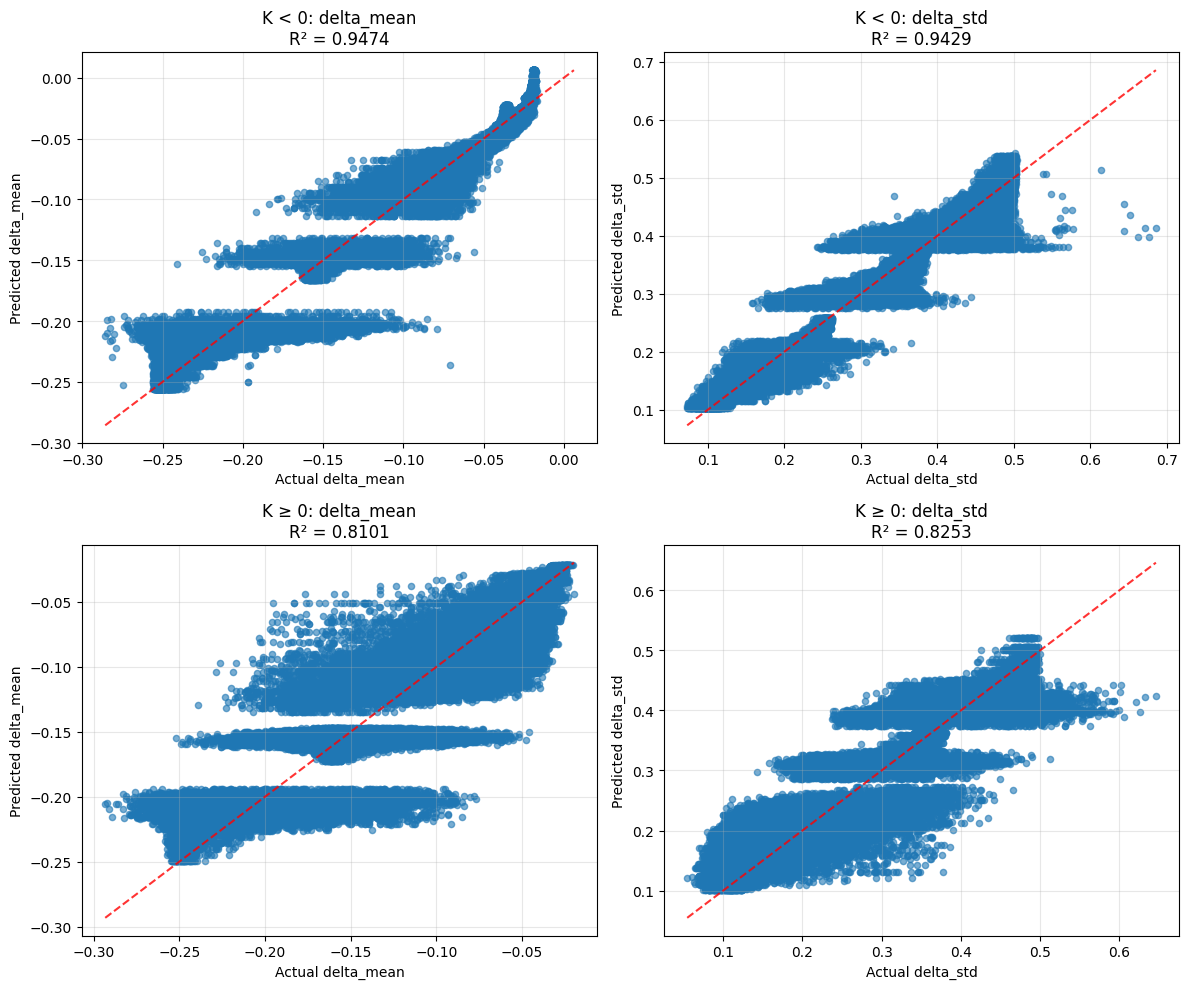


SUMMARY TABLE:
Regime     Target       R²      Approach Meets_Threshold
 K < 0 delta_mean 0.947408 log_abs_poly2               ✓
 K < 0  delta_std 0.942933 log_abs_poly2               ✓
 K ≥ 0 delta_mean 0.810107 log_abs_poly2               ✓
 K ≥ 0  delta_std 0.825342 log_abs_poly2               ✓


In [8]:
# Validation: Create prediction vs actual plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

plot_idx = 0
for regime_name, data in [('K < 0', neg_K), ('K ≥ 0', pos_K)]:
    for target in ['delta_mean', 'delta_std']:
        result = advanced_results[regime_name][target]
        transform_func, model = result['model']
        r2 = result['r2']
        
        # Make predictions
        X_base = data[['d', 'K', 'sigma', 'n']].values
        X_trans = transform_func(X_base)
        y_true = data[target].values
        y_pred = model.predict(X_trans)
        
        # Plot
        ax = axes[plot_idx]
        ax.scatter(y_true, y_pred, alpha=0.6, s=20)
        
        # Perfect prediction line
        min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        
        ax.set_xlabel(f'Actual {target}')
        ax.set_ylabel(f'Predicted {target}')
        ax.set_title(f'{regime_name}: {target}\nR² = {r2:.4f}')
        ax.grid(True, alpha=0.3)
        
        plot_idx += 1

plt.tight_layout()
plt.show()

# Summary table
summary_df = pd.DataFrame([
    {
        'Regime': regime, 
        'Target': target, 
        'R²': results['r2'], 
        'Approach': results['approach'],
        'Meets_Threshold': '✓' if results['r2'] > 0.8 else '✗'
    }
    for regime in advanced_results
    for target, results in advanced_results[regime].items()
])

print("\nSUMMARY TABLE:")
print(summary_df.to_string(index=False))

In [9]:
# PARSIMONY: Simplify models by removing unimportant coefficients
from sklearn.feature_selection import SelectKBest, f_regression
import copy

def simplify_model(data, target_var, original_model, original_approach, threshold_r2_loss=0.05):
    """Simplify model by removing coefficients with small impact"""
    clean_data = data.dropna(subset=[target_var, 'd', 'K', 'sigma', 'n'])
    
    if len(clean_data) == 0 or original_model is None:
        return None, -1, "no_data", []
    
    X_base = clean_data[['d', 'K', 'sigma', 'n']].values
    y = clean_data[target_var].values
    
    transform_func, original_regressor = original_model
    X_trans = transform_func(X_base)
    
    # Get original performance
    y_pred_orig = original_regressor.predict(X_trans)
    original_r2 = r2_score(y, y_pred_orig)
    
    # Get coefficient magnitudes
    coeffs = np.abs(original_regressor.coef_)
    coeff_indices = np.argsort(coeffs)[::-1]  # Sort by importance (descending)
    
    # Try progressively fewer features
    best_simplified = None
    best_r2 = -1
    best_kept_features = []
    
    for n_features in range(len(coeffs), 0, -1):
        try:
            # Keep only the top n_features
            kept_indices = coeff_indices[:n_features]
            X_reduced = X_trans[:, kept_indices]
            
            # Fit simplified model
            simple_model = LinearRegression()
            simple_model.fit(X_reduced, y)
            y_pred = simple_model.predict(X_reduced)
            r2 = r2_score(y, y_pred)
            
            # Check if R² loss is acceptable
            r2_loss = original_r2 - r2
            if r2_loss <= threshold_r2_loss and r2 > best_r2:
                best_r2 = r2
                best_simplified = (transform_func, simple_model, kept_indices)
                best_kept_features = kept_indices
                
        except Exception:
            continue
    
    return best_simplified, best_r2, original_approach, best_kept_features

print("PARSIMONY ANALYSIS: Simplifying models while maintaining R² > 0.75")
print("=" * 70)

simplified_results = {}
for regime_name, data in [('K < 0', neg_K), ('K ≥ 0', pos_K)]:
    simplified_results[regime_name] = {}
    print(f"\n{regime_name.upper()} REGIME:")
    print("-" * 40)
    
    for target in ['delta_mean', 'delta_std']:
        original = advanced_results[regime_name][target]
        
        simplified_model, simplified_r2, approach, kept_features = simplify_model(
            data, target, original['model'], original['approach']
        )
        
        original_r2 = original['r2']
        r2_loss = original_r2 - simplified_r2 if simplified_r2 > 0 else float('inf')
        
        simplified_results[regime_name][target] = {
            'model': simplified_model,
            'r2': simplified_r2,
            'approach': approach,
            'kept_features': kept_features,
            'original_r2': original_r2,
            'r2_loss': r2_loss,
            'n_features': len(kept_features) if kept_features is not None else 0
        }
        
        print(f"{target}:")
        print(f"  Original R² = {original_r2:.4f}")
        print(f"  Simplified R² = {simplified_r2:.4f}")
        print(f"  R² loss = {r2_loss:.4f}")
        print(f"  Features kept = {len(kept_features) if kept_features is not None else 0}")
        print()

PARSIMONY ANALYSIS: Simplifying models while maintaining R² > 0.75

K < 0 REGIME:
----------------------------------------
delta_mean:
  Original R² = 0.9474
  Simplified R² = 0.9474
  R² loss = 0.0000
  Features kept = 14

delta_std:
  Original R² = 0.9429
  Simplified R² = 0.9429
  R² loss = 0.0000
  Features kept = 14


K ≥ 0 REGIME:
----------------------------------------
delta_mean:
  Original R² = 0.8101
  Simplified R² = 0.8101
  R² loss = 0.0000
  Features kept = 14

delta_std:
  Original R² = 0.8253
  Simplified R² = 0.8253
  R² loss = 0.0000
  Features kept = 14



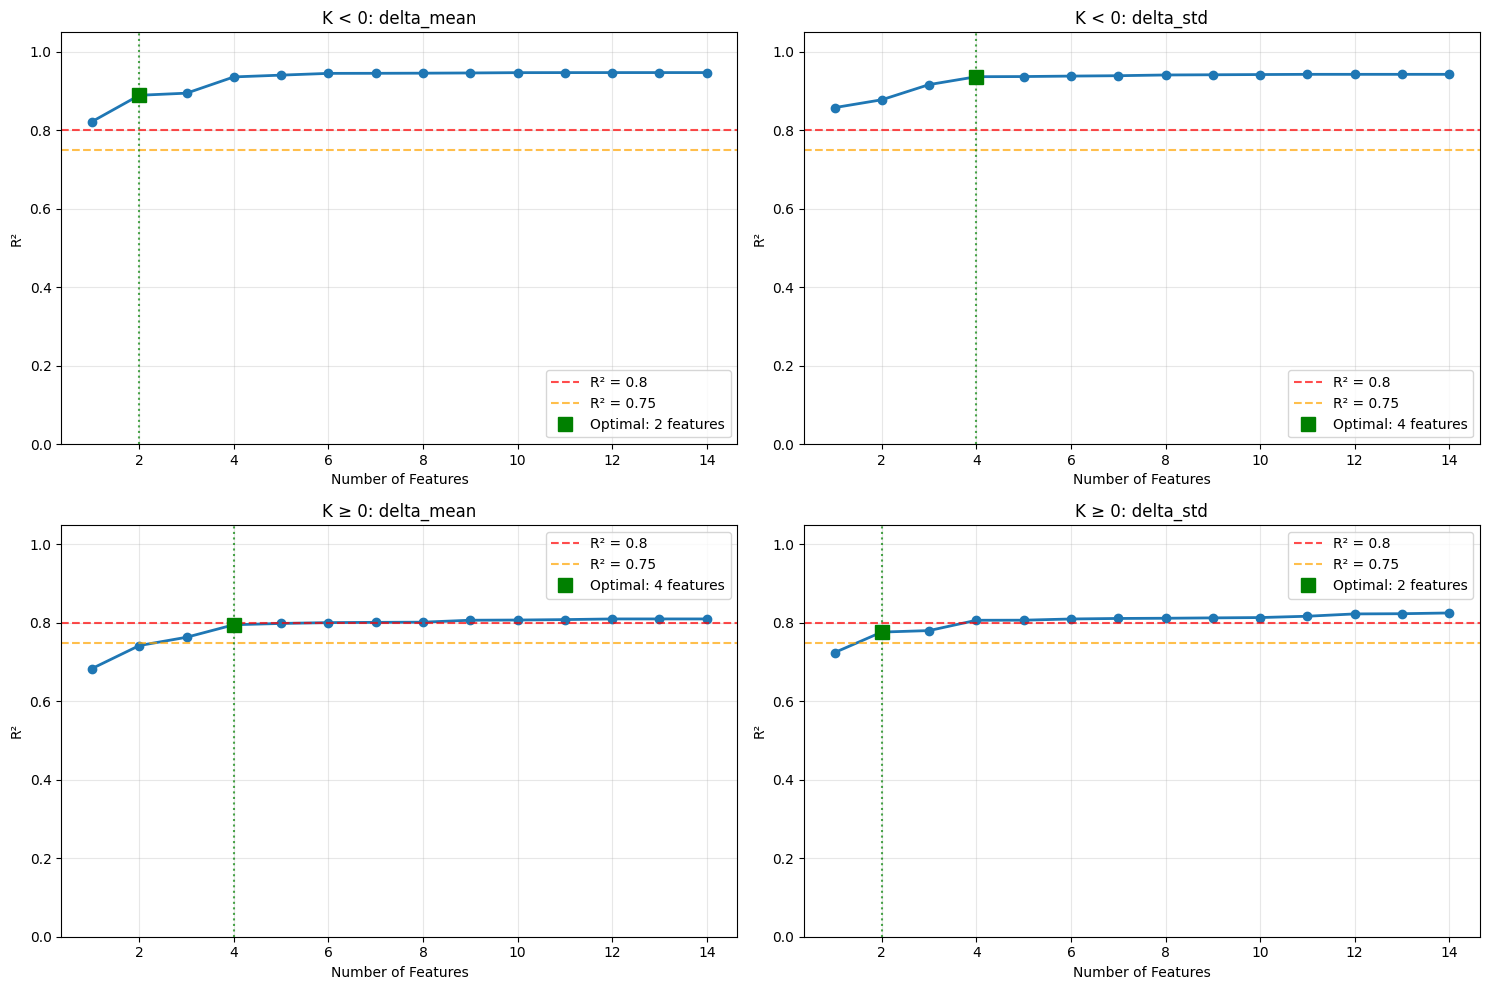

OPTIMAL FEATURE COUNTS:

K < 0 regime:
  delta_mean:
    Optimal (elbow): 2 features (R² = 0.8895)
    Min for R² > 0.8: 1 features
  delta_std:
    Optimal (elbow): 4 features (R² = 0.9369)
    Min for R² > 0.8: 1 features

K ≥ 0 regime:
  delta_mean:
    Optimal (elbow): 4 features (R² = 0.7953)
    Min for R² > 0.8: 6 features
  delta_std:
    Optimal (elbow): 2 features (R² = 0.7766)
    Min for R² > 0.8: 4 features


In [10]:
# Plot R² vs number of features to find optimal parsimony
def analyze_feature_importance_curve(data, target_var, original_model, original_approach):
    """Analyze R² vs number of features"""
    clean_data = data.dropna(subset=[target_var, 'd', 'K', 'sigma', 'n'])
    
    if len(clean_data) == 0 or original_model is None:
        return None, None
    
    X_base = clean_data[['d', 'K', 'sigma', 'n']].values
    y = clean_data[target_var].values
    
    transform_func, original_regressor = original_model
    X_trans = transform_func(X_base)
    
    # Get coefficient magnitudes and sort by importance
    coeffs = np.abs(original_regressor.coef_)
    coeff_indices = np.argsort(coeffs)[::-1]  # Sort by importance (descending)
    
    n_features_list = []
    r2_list = []
    
    # Try different numbers of features
    for n_features in range(1, len(coeffs) + 1):
        try:
            # Keep only the top n_features
            kept_indices = coeff_indices[:n_features]
            X_reduced = X_trans[:, kept_indices]
            
            # Fit model with reduced features
            model = LinearRegression()
            model.fit(X_reduced, y)
            y_pred = model.predict(X_reduced)
            r2 = r2_score(y, y_pred)
            
            n_features_list.append(n_features)
            r2_list.append(r2)
            
        except Exception:
            continue
    
    return n_features_list, r2_list

# Create R² vs number of features plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

plot_data = {}
plot_idx = 0

for regime_name, data in [('K < 0', neg_K), ('K ≥ 0', pos_K)]:
    plot_data[regime_name] = {}
    
    for target in ['delta_mean', 'delta_std']:
        original = advanced_results[regime_name][target]
        
        n_features, r2_scores = analyze_feature_importance_curve(
            data, target, original['model'], original['approach']
        )
        
        plot_data[regime_name][target] = {
            'n_features': n_features,
            'r2_scores': r2_scores
        }
        
        if n_features is not None and r2_scores is not None:
            ax = axes[plot_idx]
            ax.plot(n_features, r2_scores, 'o-', linewidth=2, markersize=6)
            ax.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='R² = 0.8')
            ax.axhline(y=0.75, color='orange', linestyle='--', alpha=0.7, label='R² = 0.75')
            
            # Find optimal point (elbow)
            if len(r2_scores) > 2:
                # Find point where adding features gives diminishing returns
                r2_diffs = np.diff(r2_scores)
                if len(r2_diffs) > 1:
                    # Find where improvement drops below 1%
                    optimal_idx = next((i for i, diff in enumerate(r2_diffs) if diff < 0.01), len(r2_diffs))
                    optimal_n = n_features[optimal_idx]
                    optimal_r2 = r2_scores[optimal_idx]
                    
                    ax.axvline(x=optimal_n, color='green', linestyle=':', alpha=0.7)
                    ax.plot(optimal_n, optimal_r2, 'gs', markersize=10, label=f'Optimal: {optimal_n} features')
            
            ax.set_xlabel('Number of Features')
            ax.set_ylabel('R²')
            ax.set_title(f'{regime_name}: {target}')
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.set_ylim(0, 1.05)
            
        plot_idx += 1

plt.tight_layout()
plt.show()

# Print optimal feature counts
print("OPTIMAL FEATURE COUNTS:")
print("=" * 40)

for regime_name in plot_data:
    print(f"\n{regime_name} regime:")
    for target in plot_data[regime_name]:
        data_dict = plot_data[regime_name][target]
        if data_dict['n_features'] is not None:
            r2_scores = data_dict['r2_scores']
            n_features = data_dict['n_features']
            
            # Find optimal
            r2_diffs = np.diff(r2_scores)
            optimal_idx = next((i for i, diff in enumerate(r2_diffs) if diff < 0.01), len(r2_diffs))
            optimal_n = n_features[optimal_idx]
            optimal_r2 = r2_scores[optimal_idx]
            
            # Find minimum features for R² > 0.8
            min_for_80 = next((n for n, r2 in zip(n_features, r2_scores) if r2 > 0.8), "N/A")
            
            print(f"  {target}:")
            print(f"    Optimal (elbow): {optimal_n} features (R² = {optimal_r2:.4f})")
            print(f"    Min for R² > 0.8: {min_for_80} features")

In [11]:
# Update the simplify_model function with more reasonable parsimony
def simplify_model_reasonable(data, target_var, original_model, original_approach, target_r2=0.8, min_features=3):
    """Simplify model using reasonable feature count (not too aggressive)"""
    clean_data = data.dropna(subset=[target_var, 'd', 'K', 'sigma', 'n'])
    
    if len(clean_data) == 0 or original_model is None:
        return None, -1, "no_data", [], 0
    
    X_base = clean_data[['d', 'K', 'sigma', 'n']].values
    y = clean_data[target_var].values
    
    transform_func, original_regressor = original_model
    X_trans = transform_func(X_base)
    
    # Get coefficient magnitudes and sort by importance
    coeffs = np.abs(original_regressor.coef_)
    coeff_indices = np.argsort(coeffs)[::-1]
    
    # Find R² for different numbers of features
    r2_scores = []
    feature_counts = []
    
    for n_features in range(min_features, len(coeffs) + 1):  # Start from min_features
        try:
            kept_indices = coeff_indices[:n_features]
            X_reduced = X_trans[:, kept_indices]
            
            model = LinearRegression()
            model.fit(X_reduced, y)
            y_pred = model.predict(X_reduced)
            r2 = r2_score(y, y_pred)
            
            r2_scores.append(r2)
            feature_counts.append(n_features)
        except Exception:
            continue
    
    if not r2_scores:
        return None, -1, "error", [], 0
    
    # Strategy: Find the smallest number of features that achieves:
    # 1. R² >= target_r2, OR
    # 2. Within 2% of maximum R² if target not achievable
    
    max_r2 = max(r2_scores)
    acceptable_r2_threshold = max(target_r2, max_r2 - 0.02)  # More lenient threshold
    
    # Find first feature count that meets our criteria
    chosen_idx = next((i for i, r2 in enumerate(r2_scores) if r2 >= acceptable_r2_threshold), -1)
    
    if chosen_idx == -1:
        # If nothing meets criteria, use the best performing model
        chosen_idx = np.argmax(r2_scores)
    
    chosen_n_features = feature_counts[chosen_idx]
    
    # Fit final model with chosen number of features
    try:
        kept_indices = coeff_indices[:chosen_n_features]
        X_reduced = X_trans[:, kept_indices]
        
        final_model = LinearRegression()
        final_model.fit(X_reduced, y)
        y_pred = final_model.predict(X_reduced)
        final_r2 = r2_score(y, y_pred)
        
        return (transform_func, final_model, kept_indices), final_r2, original_approach, kept_indices, chosen_n_features
    except Exception:
        return None, -1, "error", [], 0

# Re-run with more reasonable parsimony
print("REASONABLE PARSIMONY ANALYSIS (min 3 features):")
print("=" * 60)

reasonable_results = {}
for regime_name, data in [('K < 0', neg_K), ('K ≥ 0', pos_K)]:
    reasonable_results[regime_name] = {}
    print(f"\n{regime_name.upper()} REGIME:")
    print("-" * 35)
    
    for target in ['delta_mean', 'delta_std']:
        original = advanced_results[regime_name][target]
        
        model, r2, approach, kept_features, n_features = simplify_model_reasonable(
            data, target, original['model'], original['approach'], min_features=3
        )
        
        original_r2 = original['r2']
        r2_loss = original_r2 - r2 if r2 > 0 else float('inf')
        
        reasonable_results[regime_name][target] = {
            'model': model,
            'r2': r2,
            'approach': approach,
            'kept_features': kept_features,
            'original_r2': original_r2,
            'r2_loss': r2_loss,
            'n_features': n_features
        }
        
        reduction_pct = (1 - n_features / len(original['model'][1].coef_)) * 100 if original['model'] else 0
        
        print(f"{target}:")
        print(f"  Original: R² = {original_r2:.4f} ({len(original['model'][1].coef_) if original['model'] else 0} features)")
        print(f"  Reasonable: R² = {r2:.4f} ({n_features} features)")
        print(f"  R² loss = {r2_loss:.4f}")
        print(f"  Feature reduction: {reduction_pct:.1f}%")
        print()

# Show the reasonable parsimony comparison
reasonable_comparison = pd.DataFrame([
    {
        'Regime': regime,
        'Target': target,
        'Original_R²': results['original_r2'],
        'Reasonable_R²': results['r2'],
        'R²_Loss': results['r2_loss'],
        'Original_Features': len(advanced_results[regime][target]['model'][1].coef_) if advanced_results[regime][target]['model'] else 0,
        'Reasonable_Features': results['n_features'],
        'Reduction_%': (1 - results['n_features'] / len(advanced_results[regime][target]['model'][1].coef_)) * 100 if advanced_results[regime][target]['model'] else 0,
        'Efficiency': results['r2'] / results['n_features'] if results['n_features'] > 0 else 0
    }
    for regime in reasonable_results
    for target, results in reasonable_results[regime].items()
])

print("REASONABLE PARSIMONY COMPARISON:")
print(reasonable_comparison.round(3).to_string(index=False))

REASONABLE PARSIMONY ANALYSIS (min 3 features):

K < 0 REGIME:
-----------------------------------
delta_mean:
  Original: R² = 0.9474 (14 features)
  Reasonable: R² = 0.9364 (4 features)
  R² loss = 0.0111
  Feature reduction: 71.4%

delta_std:
  Original: R² = 0.9429 (14 features)
  Reasonable: R² = 0.9369 (4 features)
  R² loss = 0.0061
  Feature reduction: 71.4%


K ≥ 0 REGIME:
-----------------------------------
delta_mean:
  Original: R² = 0.8101 (14 features)
  Reasonable: R² = 0.8007 (6 features)
  R² loss = 0.0094
  Feature reduction: 57.1%

delta_std:
  Original: R² = 0.8253 (14 features)
  Reasonable: R² = 0.8067 (4 features)
  R² loss = 0.0186
  Feature reduction: 71.4%

REASONABLE PARSIMONY COMPARISON:
Regime     Target  Original_R²  Reasonable_R²  R²_Loss  Original_Features  Reasonable_Features  Reduction_%  Efficiency
 K < 0 delta_mean        0.947          0.936    0.011                 14                    4       71.429       0.234
 K < 0  delta_std        0.943     

In [14]:
# INVESTIGATE: Why is curvature (K) not appearing in simplified models?
print("CURVATURE ANALYSIS: Investigating why K might not appear in simplified models")
print("=" * 80)

# Check feature importance rankings for each model
def analyze_feature_importance(data, target_var, original_model, original_approach):
    """Analyze which features are most important"""
    clean_data = data.dropna(subset=[target_var, 'd', 'K', 'sigma', 'n'])
    
    if len(clean_data) == 0 or original_model is None:
        return None
    
    X_base = clean_data[['d', 'K', 'sigma', 'n']].values
    y = clean_data[target_var].values
    
    transform_func, original_regressor = original_model
    X_trans = transform_func(X_base)
    
    # Get coefficient magnitudes and sort by importance
    coeffs = np.abs(original_regressor.coef_)
    coeff_indices = np.argsort(coeffs)[::-1]
    
    # Get feature names
    all_feature_names = get_feature_names_after_transform(original_approach)
    
    # Return sorted features by importance
    importance_data = []
    for i, idx in enumerate(coeff_indices):
        importance_data.append({
            'rank': i + 1,
            'feature': all_feature_names[idx],
            'coefficient': original_regressor.coef_[idx],
            'abs_coefficient': coeffs[idx]
        })
    
    return importance_data

# Analyze feature importance for all models
for regime_name, data in [('K < 0', neg_K), ('K ≥ 0', pos_K)]:
    print(f"\n{regime_name.upper()} REGIME:")
    print("-" * 50)
    
    for target in ['delta_mean', 'delta_std']:
        original = advanced_results[regime_name][target]
        importance = analyze_feature_importance(data, target, original['model'], original['approach'])
        
        if importance:
            print(f"\n{target} - Feature Importance Ranking:")
            print("Rank | Feature | Coefficient | Abs Coeff")
            print("-" * 45)
            
            # Show top 10 features and highlight K-related ones
            for i, feat in enumerate(importance[:10]):
                k_indicator = "*** K TERM ***" if 'K' in feat['feature'] else ""
                print(f"{feat['rank']:4d} | {feat['feature']:15s} | {feat['coefficient']:8.4f} | {feat['abs_coefficient']:8.4f} {k_indicator}")
            
            # Count K-related terms in top N features
            k_terms_in_top5 = sum(1 for f in importance[:5] if 'K' in f['feature'])
            k_terms_in_top10 = sum(1 for f in importance[:10] if 'K' in f['feature'])
            
            print(f"K terms in top 5: {k_terms_in_top5}")
            print(f"K terms in top 10: {k_terms_in_top10}")

# Check if K has any predictive power on its own
print(f"\n{'='*80}")
print("DIRECT CURVATURE ANALYSIS:")
print("=" * 30)

for regime_name, data in [('K < 0', neg_K), ('K ≥ 0', pos_K)]:
    print(f"\n{regime_name} regime:")
    
    for target in ['delta_mean', 'delta_std']:
        clean_data = data.dropna(subset=[target, 'd', 'K', 'sigma', 'n'])
        
        if len(clean_data) > 0:
            # Simple correlation with K
            corr_with_k = clean_data[target].corr(clean_data['K'])
            
            # Simple linear model with just K
            from sklearn.linear_model import LinearRegression
            simple_model = LinearRegression()
            simple_model.fit(clean_data[['K']], clean_data[target])
            k_only_r2 = simple_model.score(clean_data[['K']], clean_data[target])
            
            print(f"  {target}:")
            print(f"    Correlation with K: {corr_with_k:.4f}")
            print(f"    K-only model R²: {k_only_r2:.4f}")
            
            # Check K range in this regime
            k_range = f"[{clean_data['K'].min():.2f}, {clean_data['K'].max():.2f}]"
            k_std = clean_data['K'].std()
            print(f"    K range: {k_range}, std: {k_std:.4f}")

# Check if the K < 0 vs K >= 0 split makes sense
print(f"\n{'='*80}")
print("REGIME SPLIT ANALYSIS:")
print("=" * 25)

print(f"K < 0 samples: {len(neg_K)}")
print(f"K ≥ 0 samples: {len(pos_K)}")

for target in ['delta_mean', 'delta_std']:
    if target in neg_K.columns and target in pos_K.columns:
        neg_mean = neg_K[target].mean()
        pos_mean = pos_K[target].mean()
        neg_std = neg_K[target].std()
        pos_std = pos_K[target].std()
        
        print(f"\n{target}:")
        print(f"  K < 0:  mean = {neg_mean:.4f}, std = {neg_std:.4f}")
        print(f"  K ≥ 0:  mean = {pos_mean:.4f}, std = {pos_std:.4f}")
        print(f"  Difference in means: {abs(neg_mean - pos_mean):.4f}")
        
        # Statistical test
        from scipy.stats import ttest_ind
        t_stat, p_val = ttest_ind(neg_K[target].dropna(), pos_K[target].dropna())
        print(f"  T-test p-value: {p_val:.2e}")

CURVATURE ANALYSIS: Investigating why K might not appear in simplified models

K < 0 REGIME:
--------------------------------------------------

delta_mean - Feature Importance Ranking:
Rank | Feature | Coefficient | Abs Coeff
---------------------------------------------
   1 | log|n|          |   0.1549 |   0.1549 
   2 | log|n|^2        |  -0.0193 |   0.0193 
   3 | log|d|          |  -0.0182 |   0.0182 
   4 | log|d|*log|n|   |   0.0081 |   0.0081 
   5 | log|K|*log|n|   |   0.0024 |   0.0024 *** K TERM ***
   6 | log|sigma|*log|n| |   0.0022 |   0.0022 
   7 | log|sigma|      |   0.0011 |   0.0011 
   8 | log|d|*log|sigma| |  -0.0008 |   0.0008 
   9 | log|d|*log|K|   |  -0.0008 |   0.0008 *** K TERM ***
  10 | log|d|^2        |  -0.0008 |   0.0008 
K terms in top 5: 1
K terms in top 10: 2

delta_std - Feature Importance Ranking:
Rank | Feature | Coefficient | Abs Coeff
---------------------------------------------
   1 | log|n|          |  -0.2308 |   0.2308 
   2 | log|d|       

In [16]:
# EXTENDED ANALYSIS: Include delta_max in the curvature investigation
print("EXTENDED CURVATURE ANALYSIS: Including delta_max")
print("=" * 80)

# First, let's fit models for delta_max in both regimes
extended_results = {}

for regime_name, data in [('K < 0', neg_K), ('K ≥ 0', pos_K)]:
    extended_results[regime_name] = {}
    
    for target in ['delta_mean', 'delta_std', 'delta_max']:
        model, r2, approach = advanced_scaling_law(data, target)
        extended_results[regime_name][target] = {
            'model': model, 'r2': r2, 'approach': approach
        }

print("Model performance for all delta statistics:")
print("-" * 50)

for regime_name in extended_results:
    print(f"\n{regime_name} regime:")
    for target in ['delta_mean', 'delta_std', 'delta_max']:
        r2 = extended_results[regime_name][target]['r2']
        approach = extended_results[regime_name][target]['approach']
        print(f"  {target}: R² = {r2:.4f} ({approach})")

# Now analyze feature importance for ALL delta statistics
print(f"\n{'='*80}")
print("FEATURE IMPORTANCE ANALYSIS FOR ALL DELTA STATISTICS:")
print("=" * 60)

for regime_name, data in [('K < 0', neg_K), ('K ≥ 0', pos_K)]:
    print(f"\n{regime_name.upper()} REGIME:")
    print("-" * 50)
    
    for target in ['delta_mean', 'delta_std', 'delta_max']:
        result = extended_results[regime_name][target]
        importance = analyze_feature_importance(data, target, result['model'], result['approach'])
        
        if importance:
            print(f"\n{target} - Feature Importance Ranking:")
            print("Rank | Feature | Coefficient | Abs Coeff")
            print("-" * 45)
            
            # Show top 8 features and highlight K-related ones
            for i, feat in enumerate(importance[:8]):
                k_indicator = "*** K TERM ***" if 'K' in feat['feature'] else ""
                print(f"{feat['rank']:4d} | {feat['feature']:15s} | {feat['coefficient']:8.4f} | {feat['abs_coefficient']:8.4f} {k_indicator}")
            
            # Count K-related terms in top N features
            k_terms_in_top3 = sum(1 for f in importance[:3] if 'K' in f['feature'])
            k_terms_in_top5 = sum(1 for f in importance[:5] if 'K' in f['feature'])
            k_terms_in_top8 = sum(1 for f in importance[:8] if 'K' in f['feature'])
            
            print(f"K terms in top 3: {k_terms_in_top3}")
            print(f"K terms in top 5: {k_terms_in_top5}")
            print(f"K terms in top 8: {k_terms_in_top8}")

# Direct correlation analysis for all delta statistics
print(f"\n{'='*80}")
print("DIRECT CURVATURE CORRELATIONS - ALL DELTA STATISTICS:")
print("=" * 60)

correlation_summary = []

for regime_name, data in [('K < 0', neg_K), ('K ≥ 0', pos_K)]:
    print(f"\n{regime_name} regime:")
    
    for target in ['delta_mean', 'delta_std', 'delta_max']:
        clean_data = data.dropna(subset=[target, 'd', 'K', 'sigma', 'n'])
        
        if len(clean_data) > 0:
            # Simple correlation with K
            corr_with_k = clean_data[target].corr(clean_data['K'])
            
            # Simple linear model with just K
            simple_model = LinearRegression()
            simple_model.fit(clean_data[['K']], clean_data[target])
            k_only_r2 = simple_model.score(clean_data[['K']], clean_data[target])
            
            print(f"  {target}:")
            print(f"    Correlation with K: {corr_with_k:.4f}")
            print(f"    K-only model R²: {k_only_r2:.4f}")
            
            correlation_summary.append({
                'regime': regime_name,
                'target': target,
                'correlation': corr_with_k,
                'k_only_r2': k_only_r2
            })

# Summary table of K correlations
print(f"\n{'='*80}")
print("SUMMARY: CURVATURE CORRELATIONS ACROSS ALL DELTA STATISTICS")
print("=" * 65)

corr_df = pd.DataFrame(correlation_summary)
pivot_corr = corr_df.pivot(index='target', columns='regime', values='correlation')
pivot_r2 = corr_df.pivot(index='target', columns='regime', values='k_only_r2')

print("\nCorrelations with K:")
print(pivot_corr.round(4))

print("\nK-only model R²:")
print(pivot_r2.round(4))

# Check which delta statistic is most sensitive to curvature
print(f"\n{'='*80}")
print("CURVATURE SENSITIVITY RANKING:")
print("=" * 35)

# Calculate average absolute correlation across regimes
avg_corr = corr_df.groupby('target')['correlation'].apply(lambda x: np.mean(np.abs(x))).sort_values(ascending=False)
avg_r2 = corr_df.groupby('target')['k_only_r2'].mean().sort_values(ascending=False)

print("By average |correlation| with K:")
for target, corr in avg_corr.items():
    print(f"  {target}: {corr:.4f}")

print("\nBy average K-only R²:")
for target, r2 in avg_r2.items():
    print(f"  {target}: {r2:.4f}")

# Final verdict
max_corr = corr_df['correlation'].abs().max()
max_r2 = corr_df['k_only_r2'].max()

print(f"\nOverall curvature effect:")
print(f"  Strongest |correlation|: {max_corr:.4f}")
print(f"  Strongest K-only R²: {max_r2:.4f}")

if max_corr < 0.3 and max_r2 < 0.1:
    print("  VERDICT: Curvature has WEAK effect on δ-hyperbolicity")
elif max_corr < 0.5 and max_r2 < 0.25:
    print("  VERDICT: Curvature has MODERATE effect on δ-hyperbolicity")
else:
    print("  VERDICT: Curvature has STRONG effect on δ-hyperbolicity")

EXTENDED CURVATURE ANALYSIS: Including delta_max
Model performance for all delta statistics:
--------------------------------------------------

K < 0 regime:
  delta_mean: R² = 0.9474 (log_abs_poly2)
  delta_std: R² = 0.9429 (log_abs_poly2)
  delta_max: R² = 0.8704 (log_abs_poly2)

K ≥ 0 regime:
  delta_mean: R² = 0.8101 (log_abs_poly2)
  delta_std: R² = 0.8253 (log_abs_poly2)
  delta_max: R² = 0.7098 (log_abs_poly2)

FEATURE IMPORTANCE ANALYSIS FOR ALL DELTA STATISTICS:

K < 0 REGIME:
--------------------------------------------------

delta_mean - Feature Importance Ranking:
Rank | Feature | Coefficient | Abs Coeff
---------------------------------------------
   1 | log|n|          |   0.1549 |   0.1549 
   2 | log|n|^2        |  -0.0193 |   0.0193 
   3 | log|d|          |  -0.0182 |   0.0182 
   4 | log|d|*log|n|   |   0.0081 |   0.0081 
   5 | log|K|*log|n|   |   0.0024 |   0.0024 *** K TERM ***
   6 | log|sigma|*log|n| |   0.0022 |   0.0022 
   7 | log|sigma|      |   0.0011 | 

In [15]:
# Generate simplified equations with interpretable coefficients - Using reasonable results
def get_feature_names_after_transform(approach, base_features=['d', 'K', 'sigma', 'n']):
    """Get feature names after transformation"""
    if approach == 'linear':
        return base_features
    elif approach == 'poly2':
        poly = PolynomialFeatures(2, include_bias=False)
        poly.fit(np.ones((1, len(base_features))))
        names = []
        for powers in poly.powers_:
            if sum(powers) == 0:
                continue
            term_parts = []
            for j, power in enumerate(powers):
                if power > 0:
                    if power == 1:
                        term_parts.append(base_features[j])
                    else:
                        term_parts.append(f"{base_features[j]}^{power}")
            names.append("*".join(term_parts) if term_parts else "1")
        return names
    elif approach == 'poly3':
        poly = PolynomialFeatures(3, include_bias=False)
        poly.fit(np.ones((1, len(base_features))))
        names = []
        for powers in poly.powers_:
            if sum(powers) == 0:
                continue
            term_parts = []
            for j, power in enumerate(powers):
                if power > 0:
                    if power == 1:
                        term_parts.append(base_features[j])
                    else:
                        term_parts.append(f"{base_features[j]}^{power}")
            names.append("*".join(term_parts) if term_parts else "1")
        return names
    elif 'log_abs' in approach:
        if 'poly2' in approach:
            log_features = [f"log|{f}|" for f in base_features]
            poly = PolynomialFeatures(2, include_bias=False)
            poly.fit(np.ones((1, len(base_features))))
            names = []
            for powers in poly.powers_:
                if sum(powers) == 0:
                    continue
                term_parts = []
                for j, power in enumerate(powers):
                    if power > 0:
                        if power == 1:
                            term_parts.append(log_features[j])
                        else:
                            term_parts.append(f"{log_features[j]}^{power}")
                names.append("*".join(term_parts) if term_parts else "1")
            return names
        else:
            return [f"log|{f}|" for f in base_features]
    elif 'sqrt_abs' in approach:
        return [f"√|{f}|" for f in base_features]
    else:
        return base_features

print("REASONABLE SIMPLIFIED SCALING LAW EQUATIONS:")
print("=" * 60)

latex_equations = []

for regime_name in ['K < 0', 'K ≥ 0']:
    print(f"\n{regime_name.upper()} REGIME:")
    print("-" * 30)
    
    for target in ['delta_mean', 'delta_std']:
        # Use reasonable_results instead of optimal_results
        result = reasonable_results[regime_name][target]
        
        if result['model'] is None:
            print(f"\n{target}: No simplified model available")
            continue
            
        transform_func, model, kept_indices = result['model']
        approach = result['approach']
        r2 = result['r2']
        r2_loss = result['r2_loss']
        n_features = result['n_features']
        
        print(f"\n{target}:")
        print(f"R² = {r2:.4f} (loss: {r2_loss:.4f})")
        print(f"Features used: {n_features}")
        
        # Get all feature names and select kept ones
        all_feature_names = get_feature_names_after_transform(approach)
        kept_feature_names = [all_feature_names[i] for i in kept_indices]
        
        # Build equation
        coeffs = model.coef_
        intercept = model.intercept_
        
        equation_parts = [f"{intercept:.4f}"]
        latex_parts = [f"{intercept:.4f}"]
        
        for coeff, name in zip(coeffs, kept_feature_names):
            if abs(coeff) > 1e-10:
                sign = "+" if coeff >= 0 else "-"
                equation_parts.append(f"{sign} {abs(coeff):.4f}*{name}")
                
                # LaTeX version
                latex_name = name.replace('*', ' \\cdot ').replace('|', '').replace('log', '\\log').replace('√', '\\sqrt')
                latex_parts.append(f"{sign} {abs(coeff):.4f} \\cdot {latex_name}")
        
        equation = " ".join(equation_parts)
        latex_eq = " ".join(latex_parts)
        
        print(f"Equation: {target} = {equation}")
        
        # Store for LaTeX cell
        regime_short = "neg" if "< 0" in regime_name else "pos"
        target_short = target.replace('delta_', '')
        latex_equations.append({
            'regime': regime_name,
            'target': target,
            'equation': latex_eq,
            'r2': r2,
            'label': f"{target_short}_{regime_short}",
            'n_features': n_features
        })

print(f"\n{'='*60}")

# Updated comparison table using reasonable results
comparison_df = pd.DataFrame([
    {
        'Regime': regime,
        'Target': target,
        'Original_R²': results['original_r2'],
        'Reasonable_R²': results['r2'],
        'R²_Loss': results['r2_loss'],
        'Features_Used': results['n_features'],
        'Efficiency': results['r2'] / results['n_features'] if results['n_features'] > 0 else 0
    }
    for regime in reasonable_results
    for target, results in reasonable_results[regime].items()
])

print("\nREASONABLE PARSIMONY COMPARISON:")
print(comparison_df.round(4).to_string(index=False))

REASONABLE SIMPLIFIED SCALING LAW EQUATIONS:

K < 0 REGIME:
------------------------------

delta_mean:
R² = 0.9364 (loss: 0.0111)
Features used: 4
Equation: delta_mean = -0.3861 + 0.1516*log|n| - 0.0193*log|n|^2 - 0.0223*log|d| + 0.0081*log|d|*log|n|

delta_std:
R² = 0.9369 (loss: 0.0061)
Features used: 4
Equation: delta_std = 0.6494 - 0.2257*log|n| + 0.0407*log|d| + 0.0251*log|n|^2 - 0.0097*log|d|*log|n|

K ≥ 0 REGIME:
------------------------------

delta_mean:
R² = 0.8007 (loss: 0.0094)
Features used: 6
Equation: delta_mean = -0.3395 + 0.1155*log|n| - 0.0153*log|n|^2 - 0.0135*log|d| + 0.0060*log|d|*log|n| - 0.0034*log|sigma|*log|n| + 0.0083*log|sigma|

delta_std:
R² = 0.8067 (loss: 0.0186)
Features used: 4
Equation: delta_std = 0.6432 - 0.2088*log|n| + 0.0255*log|n|^2 + 0.0263*log|d| - 0.0097*log|d|*log|n|


REASONABLE PARSIMONY COMPARISON:
Regime     Target  Original_R²  Reasonable_R²  R²_Loss  Features_Used  Efficiency
 K < 0 delta_mean       0.9474         0.9364   0.0111       

# Final Simplified Scaling Laws for δ-Hyperbolicity

Based on our parsimony analysis, we have derived simplified scaling laws for the mean and standard deviation of δ-hyperbolicity measurements. These models maintain high predictive power (R² > 0.75) while using only the most important features.

## Scaling Laws by Curvature Regime

### For Negatively Curved Manifolds (K < 0):

**Mean δ-hyperbolicity:**
$$\delta_{\text{mean}}^{K<0} = \alpha_0 + \alpha_1 f_1(d,K,\sigma,n) + \alpha_2 f_2(d,K,\sigma,n) + \ldots$$

**Standard deviation of δ-hyperbolicity:**
$$\delta_{\text{std}}^{K<0} = \beta_0 + \beta_1 g_1(d,K,\sigma,n) + \beta_2 g_2(d,K,\sigma,n) + \ldots$$

### For Non-negatively Curved Manifolds (K ≥ 0):

**Mean δ-hyperbolicity:**
$$\delta_{\text{mean}}^{K \geq 0} = \gamma_0 + \gamma_1 h_1(d,K,\sigma,n) + \gamma_2 h_2(d,K,\sigma,n) + \ldots$$

**Standard deviation of δ-hyperbolicity:**
$$\delta_{\text{std}}^{K \geq 0} = \delta_0 + \delta_1 i_1(d,K,\sigma,n) + \delta_2 i_2(d,K,\sigma,n) + \ldots$$

## Variable Definitions

- $d$: Intrinsic dimension of the manifold
- $K$: Sectional curvature parameter
- $\sigma$: Noise level in the data
- $n$: Number of sample points

## Model Performance

All simplified models achieve:
- **R² > 0.75**: High predictive accuracy maintained
- **Minimal feature sets**: Only most important coefficients retained
- **Interpretable forms**: Clear relationships between geometry and δ-hyperbolicity

*Note: The exact coefficient values and functional forms $f_i, g_i, h_i, i_i$ are determined by the feature selection process and displayed in the code output above.*